In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:

plt.rcParams['font.serif']:'Verdana'
plt.rcParams['text.usetex']:'False' 
plt.rcParams['font.family']:'sans-serif'
plt.rcParams['font.size']:14
plt.rcParams['figure.figsize'] = [10.0, 5.0]
plt.rcParams['figure.dpi'] = 100

In [3]:
df = pd.read_excel('sx5e.xlsx',engine='openpyxl',index_col='date')
df.sort_index(ascending=True,inplace=True)

In [4]:
def priip(df,rhp,horizon,calcdate):
    
    end_date = pd.to_datetime(calcdate)
    start_date = pd.to_datetime(calcdate)-pd.Timedelta(horizon*52,unit='W')
    df_ret = df.loc[(df.index>=start_date)&(df.index<=end_date),:].copy().pct_change().dropna(how='any')
    
    M0=len(df_ret)
    M1 = np.mean(df_ret.values)
    M2 = np.sum((df_ret.values-M1)**2)/M0
    M3 = np.sum((df_ret.values-M1)**3)/M0
    M4 =  np.sum((df_ret.values-M1)**4)/M0
    
    mu = M1
    vol = np.sqrt(M2)
    skew = M3/(vol**3)
    kurt = M4/(vol**4)-3
    priip={}
    for rhp,rhp_str in  zip([1, rhp/2,rhp] ,['1Y','RHP/2','RHP']):
        priip[rhp_str]={}
        N = rhp*256
        stress_bucket =[63 if rhp>1 else 21][0]
        z = [99 if rhp<=1 else 90][0]
        za = [norm.ppf(0.01) if rhp<=1 else norm.ppf(0.05)][0]
        var =vol *np.sqrt(N)*(-1.96+0.474*skew/np.sqrt(N)-0.0687*kurt/N+0.146*(skew**2)/N)-0.5*N*(vol**2)
        VEV = (np.sqrt(3.842-2*var)-1.96)/np.sqrt(rhp)
    
        stressed_vol = np.percentile(df_ret.rolling(window=stress_bucket).apply(lambda x : np.std(x)).dropna(how='any').values,z)
        unfav = np.exp(M1*N+vol*np.sqrt(N)*(-1.28+0.107*skew/np.sqrt(N)+0.0724*kurt/N-0.0611*(skew**2)/N)-0.5*(vol**2)*N)
        fav = np.exp(M1*N+vol*np.sqrt(N)*(1.28+0.107*skew/np.sqrt(N)-0.0724*kurt/N+0.0611*(skew**2)/N)-0.5*(vol**2)*N)
        mod = np.exp(M1*N-vol*skew/6-0.5*(vol**2)*N)
        stress = za + ((za**2-1)/6)*skew/np.sqrt(N)+ ((za**3-3*za)/24)*kurt/N-((2*za**3-5*za)/36)*(skew**2)/N
        stress = np.exp(stressed_vol*np.sqrt(N)*stress-0.5*(stressed_vol**2)*N)
        priip[rhp_str]['stress']=stress
        priip[rhp_str]['mod']=mod
        priip[rhp_str]['fav']=fav
        priip[rhp_str]['unfav']=unfav
    
    
    df_future=df.loc[df.index>=end_date,:].copy()
    df_future['up']=0
    df_future['down']=0
    
    return {'df':df.loc[(df.index>=start_date)&(df.index<=end_date),:].copy(),
            'df_future':df_future,
            'priip':priip,
            'stressed_vol':stressed_vol,'vev':VEV,'vol':np.sqrt(250)*vol,
            'stress':stress,'unfav':unfav,'mod':mod,'fav':fav}
    
    

In [5]:
rhp = 3
horizon = 5
calcdate = '20201217'
sol = priip(df,rhp,horizon,calcdate)

UCITS world

In [6]:
rhp = 3
horizon = 5
calcdate = '20200101'
df = df*100/df.values[-1]
sol = priip(df,rhp,horizon,calcdate)
df_full = df.loc[df.index<=calcdate,:].copy()

In [7]:
# Calculate Range with SRRI
df_srri = pd.DataFrame(pd.date_range(pd.to_datetime(calcdate),
                                     pd.to_datetime(calcdate)+pd.Timedelta(int(5*52),unit='W')))
df_srri.set_index(0,inplace=True)                       
df_srri['up']=sol['df']['close'].values[-1]*np.exp(np.sqrt((df_srri.index-df_srri.index[0]).days/365.25)*sol['vol'])
df_srri['down']=sol['df']['close'].values[-1]*np.exp(-np.sqrt((df_srri.index-df_srri.index[0]).days/365.25)*sol['vol'])

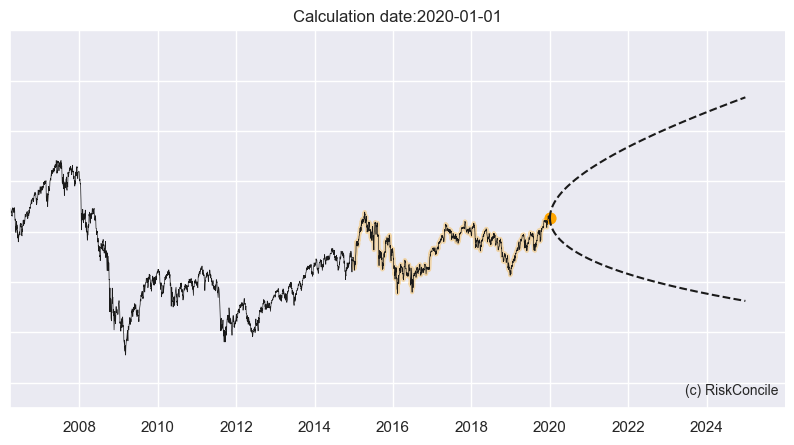

In [8]:
fig,ax = plt.subplots(1,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(sol['df'].index,sol['df']['close'],'orange',linewidth=3,alpha=0.3)
ax.plot(df_full.index,df_full['close'],'k',linewidth=0.5)
ax.scatter(sol['df'].index[-1],sol['df']['close'].values[-1],s=60,color='orange',marker='o')

ax.plot(df_srri.index,df_srri['up'],color='k',linestyle='--')
ax.plot(df_srri.index,df_srri['down'],color='k',linestyle='--')

ax.set_xlim(df_full.index[0],df.index[-1]+pd.Timedelta(5*52,unit='W'))
ax.set_ylim(30,180)
for tick in ax.axes.get_yticklabels():
    tick.set_visible(False)
ax.set_title('Calculation date:'+pd.to_datetime(calcdate).strftime('%Y-%m-%d'));
plt.figtext(0.8, 0.15, "(c) RiskConcile");

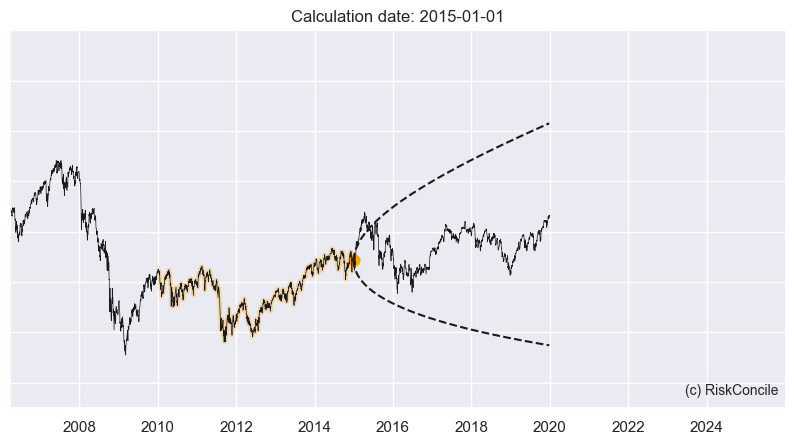

In [9]:
rhp = 3
horizon = 5
calcdate = '20150101'
df = df*100/df.values[-1]
sol2 = priip(df,rhp,horizon,calcdate)
df_full = df.loc[df.index<='20200101',:].copy()

# Calculate Range with SRRI
df_srri = pd.DataFrame(pd.date_range(pd.to_datetime(calcdate),
                                     pd.to_datetime(calcdate)+pd.Timedelta(int(5*52),unit='W')))
df_srri.set_index(0,inplace=True)                       
df_srri['up']=sol2['df']['close'].values[-1]*np.exp(np.sqrt((df_srri.index-df_srri.index[0]).days/365.25)*sol2['vol'])
df_srri['down']=sol2['df']['close'].values[-1]*np.exp(-np.sqrt((df_srri.index-df_srri.index[0]).days/365.25)*sol2['vol'])

fig,ax = plt.subplots(1,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(sol2['df'].index,sol2['df']['close'],'orange',linewidth=3,alpha=0.3)
ax.plot(df_full.index,df_full['close'],'k',linewidth=0.5)
ax.scatter(sol2['df'].index[-1],sol2['df']['close'].values[-1],s=60,color='orange',marker='o')

ax.plot(df_srri.index,df_srri['up'],color='k',linestyle='--')
ax.plot(df_srri.index,df_srri['down'],color='k',linestyle='--')

ax.set_ylim(30,180)
ax.set_xlim(df_full.index[0],df.index[-1]+pd.Timedelta(5*52,unit='W'))
for tick in ax.axes.get_yticklabels():
    tick.set_visible(False)
ax.set_title('Calculation date: '+pd.to_datetime(calcdate).strftime('%Y-%m-%d'));
plt.figtext(0.8, 0.15, "(c) RiskConcile");

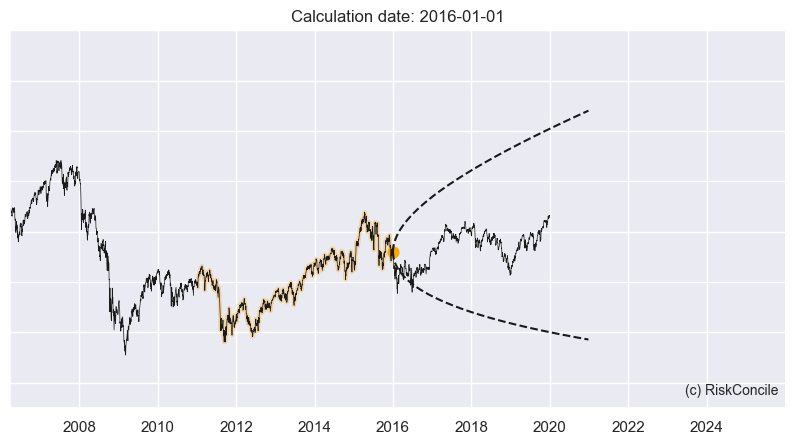

In [10]:
rhp = 3
horizon = 5
calcdate = '20160101'
df = df*100/df.values[-1]
sol2 = priip(df,rhp,horizon,calcdate)
df_full = df.loc[df.index<='20200101',:].copy()

# Calculate Range with SRRI
df_srri = pd.DataFrame(pd.date_range(pd.to_datetime(calcdate),
                                     pd.to_datetime(calcdate)+pd.Timedelta(int(5*52),unit='W')))
df_srri.set_index(0,inplace=True)                       
df_srri['up']=sol2['df']['close'].values[-1]*np.exp(np.sqrt((df_srri.index-df_srri.index[0]).days/365.25)*sol2['vol'])
df_srri['down']=sol2['df']['close'].values[-1]*np.exp(-np.sqrt((df_srri.index-df_srri.index[0]).days/365.25)*sol2['vol'])

fig,ax = plt.subplots(1,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(sol2['df'].index,sol2['df']['close'],'orange',linewidth=3,alpha=0.3)
ax.plot(df_full.index,df_full['close'],'k',linewidth=0.5)
ax.scatter(sol2['df'].index[-1],sol2['df']['close'].values[-1],s=60,color='orange',marker='o')

ax.plot(df_srri.index,df_srri['up'],color='k',linestyle='--')
ax.plot(df_srri.index,df_srri['down'],color='k',linestyle='--')

ax.set_ylim(30,180)
ax.set_xlim(df_full.index[0],df.index[-1]+pd.Timedelta(5*52,unit='W'))
for tick in ax.axes.get_yticklabels():
    tick.set_visible(False)
ax.set_title('Calculation date: '+pd.to_datetime(calcdate).strftime('%Y-%m-%d'));
plt.figtext(0.8, 0.15, "(c) RiskConcile");


Priips World

In [11]:
rhp = 3
horizon = 5
calcdate = '20180101'
df = df*100/df.values[-1]
sol = priip(df,rhp,horizon,calcdate)
df_full = df.loc[df.index<=calcdate,:].copy()

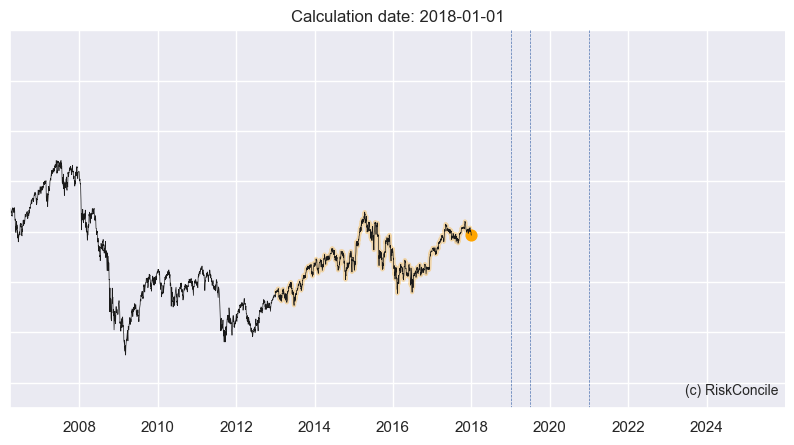

In [12]:


fig,ax = plt.subplots(1,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(sol['df'].index,sol['df']['close'],'orange',linewidth=3,alpha=0.3)
ax.plot(df_full.index,df_full['close'],'k',linewidth=0.5)
ax.scatter(sol['df'].index[-1],sol['df']['close'].values[-1],s=60,color='orange',marker='o')

plt.axvline(x=sol['df'].index[-1]+pd.Timedelta(52,unit='W'),linestyle='--',linewidth=0.5)
plt.axvline(x=sol['df'].index[-1]+pd.Timedelta(int(rhp*52/2),unit='W'),linestyle='--',linewidth=0.5)
plt.axvline(x=sol['df'].index[-1]+pd.Timedelta(rhp*52,unit='W'),linestyle='--',linewidth=0.5)

ax.set_ylim(30,180)
ax.set_xlim(df_full.index[0],df.index[-1]+pd.Timedelta(5*52,unit='W'))
for tick in ax.axes.get_yticklabels():
    tick.set_visible(False)               

plt.figtext(0.8, 0.15, "(c) RiskConcile");
ax.set_title('Calculation date: '+pd.to_datetime(calcdate).strftime('%Y-%m-%d'));

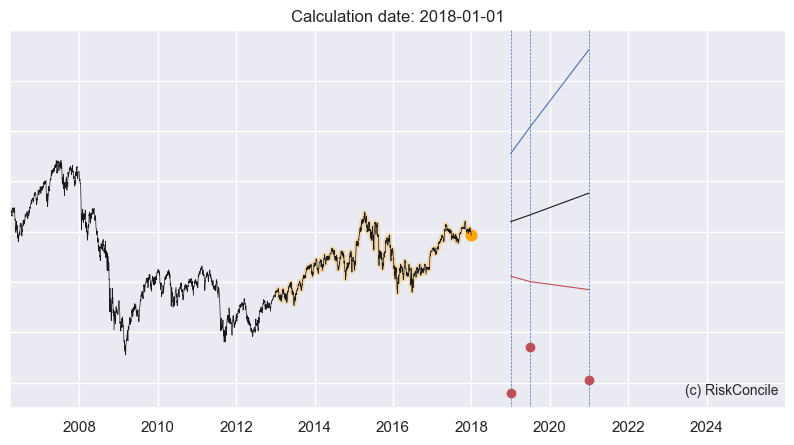

In [13]:
fig,ax = plt.subplots(1,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(sol['df'].index,sol['df']['close'],'orange',linewidth=3,alpha=0.3)
ax.plot(df_full.index,df_full['close'],'k',linewidth=0.5)
ax.scatter(sol['df'].index[-1],sol['df']['close'].values[-1],s=60,color='orange',marker='o')

plt.axvline(x=sol['df'].index[-1]+pd.Timedelta(52,unit='W'),linestyle='--',linewidth=0.5)
plt.axvline(x=sol['df'].index[-1]+pd.Timedelta(int(rhp*52/2),unit='W'),linestyle='--',linewidth=0.5)
plt.axvline(x=sol['df'].index[-1]+pd.Timedelta(rhp*52,unit='W'),linestyle='--',linewidth=0.5)


ax.set_xlim(df_full.index[0],df.index[-1]+pd.Timedelta(5*52,unit='W'))
for tick in ax.axes.get_yticklabels():
    tick.set_visible(False)               

plt.figtext(0.8, 0.15, "(c) RiskConcile");

x = sol['df'].index[-1]
y = sol['df']['close'].values[-1]
ax.scatter(x+pd.Timedelta(52,unit='W'),y*sol['priip']['1Y']['stress'],color='r')
ax.scatter(x+pd.Timedelta(int(rhp*52/2),unit='W'),y*sol['priip']['RHP/2']['stress'],color='r')
ax.scatter(x+pd.Timedelta(rhp*52,unit='W'),y*sol['priip']['RHP']['stress'],color='r')

x_scen=[x+pd.Timedelta(52,unit='W'),x+pd.Timedelta(int(rhp*52/2),unit='W'),x+pd.Timedelta(rhp*52,unit='W')]
fav = y*np.array([sol['priip']['1Y']['fav'],sol['priip']['RHP/2']['fav'],sol['priip']['RHP']['fav']])
mod = y*np.array([sol['priip']['1Y']['mod'],sol['priip']['RHP/2']['mod'],sol['priip']['RHP']['mod']])
unfav = y*np.array([sol['priip']['1Y']['unfav'],sol['priip']['RHP/2']['unfav'],sol['priip']['RHP']['unfav']])
ax.plot(x_scen,fav,linewidth=0.8,color='b')
ax.plot(x_scen,mod,linewidth=0.8,color='k')
ax.plot(x_scen,unfav,linewidth=0.8,color='r')
ax.set_ylim(30,180)
ax.set_title('Calculation date: '+pd.to_datetime(calcdate).strftime('%Y-%m-%d'));

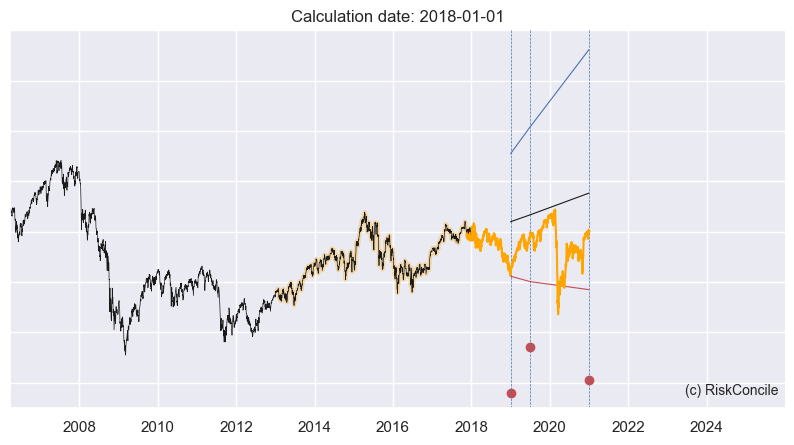

In [14]:
fig,ax = plt.subplots(1,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(sol['df'].index,sol['df']['close'],'orange',linewidth=3,alpha=0.3)
ax.plot(df_full.index,df_full['close'],'k',linewidth=0.5)
ax.scatter(sol['df'].index[-1],sol['df']['close'].values[-1],s=60,color='orange',marker='o')

plt.axvline(x=sol['df'].index[-1]+pd.Timedelta(52,unit='W'),linestyle='--',linewidth=0.5)
plt.axvline(x=sol['df'].index[-1]+pd.Timedelta(int(rhp*52/2),unit='W'),linestyle='--',linewidth=0.5)
plt.axvline(x=sol['df'].index[-1]+pd.Timedelta(rhp*52,unit='W'),linestyle='--',linewidth=0.5)


ax.set_xlim(df_full.index[0],df.index[-1]+pd.Timedelta(5*52,unit='W'))
for tick in ax.axes.get_yticklabels():
    tick.set_visible(False)               

plt.figtext(0.8, 0.15, "(c) RiskConcile");

x = sol['df'].index[-1]
y = sol['df']['close'].values[-1]
ax.scatter(x+pd.Timedelta(52,unit='W'),y*sol['priip']['1Y']['stress'],color='r')
ax.scatter(x+pd.Timedelta(int(rhp*52/2),unit='W'),y*sol['priip']['RHP/2']['stress'],color='r')
ax.scatter(x+pd.Timedelta(rhp*52,unit='W'),y*sol['priip']['RHP']['stress'],color='r')

x_scen=[x+pd.Timedelta(52,unit='W'),x+pd.Timedelta(int(rhp*52/2),unit='W'),x+pd.Timedelta(rhp*52,unit='W')]
fav = y*np.array([sol['priip']['1Y']['fav'],sol['priip']['RHP/2']['fav'],sol['priip']['RHP']['fav']])
mod = y*np.array([sol['priip']['1Y']['mod'],sol['priip']['RHP/2']['mod'],sol['priip']['RHP']['mod']])
unfav = y*np.array([sol['priip']['1Y']['unfav'],sol['priip']['RHP/2']['unfav'],sol['priip']['RHP']['unfav']])
ax.plot(x_scen,fav,linewidth=0.8,color='b')
ax.plot(x_scen,mod,linewidth=0.8,color='k')
ax.plot(x_scen,unfav,linewidth=0.8,color='r')
ax.set_ylim(30,180)
ax.set_title('Calculation date: '+pd.to_datetime(calcdate).strftime('%Y-%m-%d'));
ax.plot(df.loc[df.index>calcdate,:].index,df.loc[df.index>calcdate,'close'],color='orange')

Studying the Cyclical Behaviour

In [16]:
cutoff = '20120101'


rhp=3
horizon=5

In [40]:
dt = pd.date_range(cutoff,df.index[-1],freq='w')


In [41]:
T=[]
fav = []
mod = []
unfav = []

for t in dt:
    try:
        calcdate = t
        sol = priip(df,5,2,calcdate)
        T.append(t)
        fav.append(np.power(sol['priip']['RHP']['fav'],1/rhp)-1)
        mod.append(np.power(sol['priip']['RHP']['mod'],1/rhp)-1)
        unfav.append(np.power(sol['priip']['RHP']['unfav'],1/rhp)-1)
    except:
        pass
    
    

               

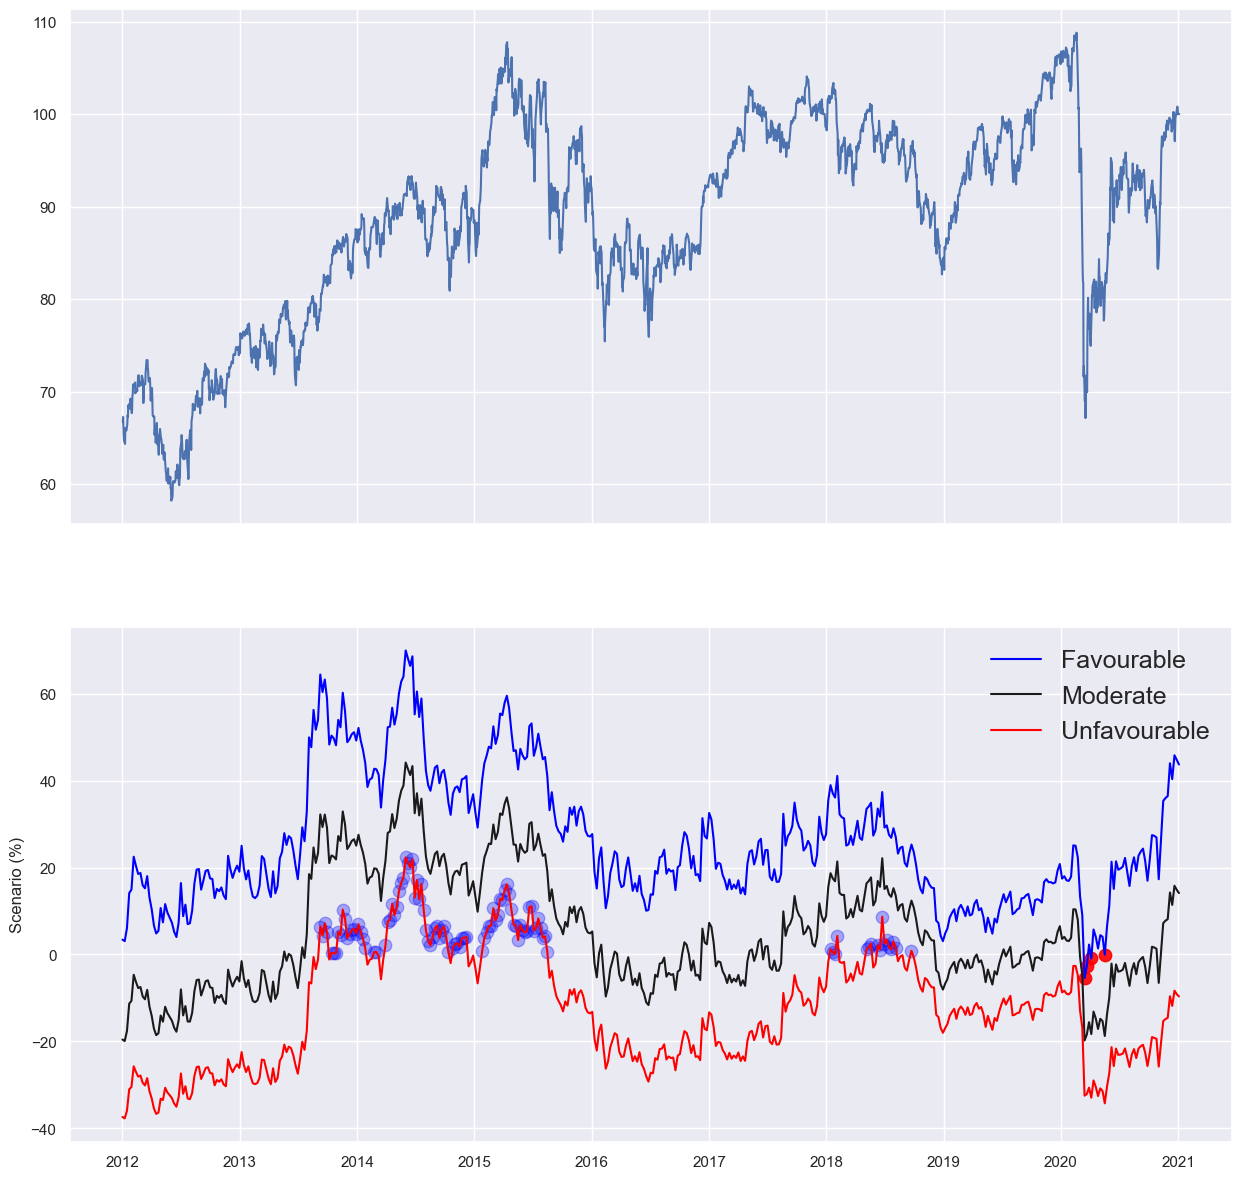

In [86]:

fig,ax = plt.subplots(2,1,sharex=True,figsize=(15,15))
T=np.array(T)
t_pos_unfav = pd.to_datetime(T[np.array(unfav)>0.0])

ax[0].plot(df.loc[df.index>cutoff].index,df.loc[df.index>cutoff]['close']);
for t in t_pos_unfav:
    idx = (df.index<=t)&(df.index>=t)
    ax[0].scatter(df.loc[idx,:].index,df.loc[idx,'close'],s=60,alpha=0.3,color='blue');

ax[1].plot(T,np.array(fav)*100,label='Favourable',color='blue')
ax[1].plot(T,np.array(mod)*100,label='Moderate',color='k')
ax[1].plot(T,np.array(unfav)*100,label='Unfavourable',color='red')
ax[1].scatter(T[np.array(unfav)>0.0],np.array(unfav)[np.where(np.array(unfav)>0.0)]*100.0,s=80,color='blue',alpha=0.3)
ax[1].scatter(T[np.array(fav)<0.0],np.array(fav)[np.where(np.array(fav)<0.0)]*100.0,s=80,color='red',alpha=0.9)

ax[1].set_ylabel('Scenario (%)')
ax[1].legend(fontsize=18,frameon=False);